In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.rc('font', size=16, family='serif')

## Load a working image

In [4]:
from PIL import Image, ImageOps

In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/juanjosegarciaripoll/uimp-2020/master/cat.png", "cat.png")

('cat.png', <http.client.HTTPMessage at 0x2268c6d6388>)

In [6]:
cat = ImageOps.grayscale(Image.open('cat.png'))

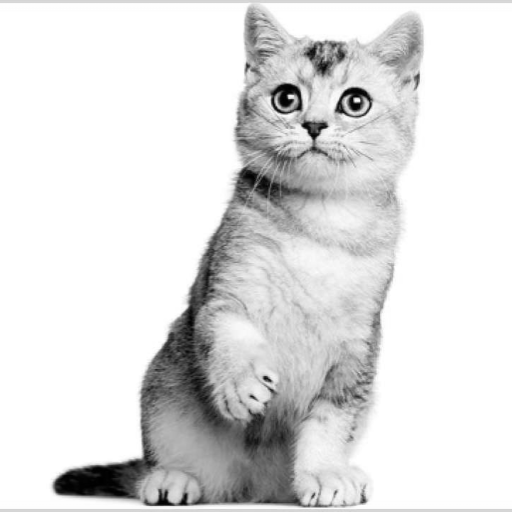

In [7]:
cat

## Convert an image to a vector of numbers

The Pillow library allows us to see how images are encoded by the computer. We convert the image to an 2D array of integers

In [8]:
cat_array = np.asarray(cat)

In [9]:
cat_array[1,1]

216

In [10]:
cat_array[100,300]

21

The computer representation qualifies the "intensity" (= whiteness) of the image as a number between 0 (black) and 255 (pure white).

In [11]:
(np.min(cat_array), np.max(cat_array))

(0, 255)

## Image as a state

We can convert this representation into a pure state. We just need to collect all numbers into a vector and normalize it,
$$|\psi\rangle = \frac{1}{\sqrt{I_T}}\sum_s \sqrt{I(s)}|s\rangle.$$
Here "s" is an index, an integer between 0 and L-1, where L is the total size of the array.

In [12]:
cat_I = cat_array.flatten()+0.0
cat_ψ = np.sqrt(cat_I)/np.sqrt(np.sum(cat_I))

In [13]:
np.linalg.norm(cat_ψ)

0.9999999999999807

## Ordering of qubits

The image we have constructed uses an integer $s=(s_1,s_2,\ldots,s_N)$ which can be decomposed into bits $s_i\in\{0,1\}.$ In our particular example, with 512x512 pixels, we only need $N=9+9=18$ bits
$$s = s_1 2^{17} + s_2 2^{16} + \ldots + s_{18}$$

In this ordering, we scan the image by rows and $(s_1,s_2,\ldots,s_{N/2})$ represent the indices of the row and $(s_{N/2+1},\ldots,s_N)$ form a binary number for the column.

We could create a different order, $(s^{row}_1,s^{col}_1,s^{row}_2,s^{row}_2,\ldots)$ that orders the bits by relevance or length-scale they describe. It uses two Python tricks

- It reshapes our quantum state as an array with $N$ indices, each of size 2.
- It then permutes the indices of the array
- And finally converts the array into a flat, 1D arrangement of numbers

In [14]:
def order_by_size(ψ, q):
    size = [2 for i in range(2*q)]
    ndx = [i + j for i in range(q) for j in [0, q]]
    return ψ.reshape(size).transpose(ndx)

This function undoes the previous transformation

In [15]:
def order_by_dimension(ψ, q):
    size = [2 for i in range(2*q)]
    ndx = [2*i + j for j in [0,1] for i in range(q)]
    return ψ.reshape(size).transpose(ndx)

## Image conversions

We can now write a better function, that converts a generic image to a quantum state, but allows us to choose the ordering.

In [16]:
def image2state(image, reorder=True):
    
    # Convert image to an array
    image = ImageOps.grayscale(image)
    image_I = np.asarray(image)
    
    # Reshape to fit some qubit size, the same for both dimensions
    L1, L2 = image_I.shape
    q1 = int(round(np.log2(L1)))
    q2 = int(round(np.log2(L2)))
    q = max(q1, q2)
    L = 2**q
    new_I = np.zeros((L, L), dtype=np.float64)
    new_I[0:L1,0:L2] = image_I
    
    I_t = np.sum(new_I.flatten())
    ψ = np.sqrt(new_I.flatten())/np.sqrt(I_t)
    
    if reorder:
        ψ = order_by_size(ψ, q)
    
    return ψ

And we can even take a quantum state and convert it into an image. We assume a square image with the same number of qubits along both dimensions.

In [17]:
def intensity2image(I):
    I = np.uint8(np.round(I/np.max(I) * 255.0))
    return Image.fromarray(I)

In [18]:
def state2image(ψ, reorder=True):
    q = int(round(np.log2(ψ.size))) // 2
    L = 2**q
    if reorder:
        ψ = order_by_dimension(ψ, q)
    return intensity2image(np.abs(ψ*ψ).reshape((L,L)))

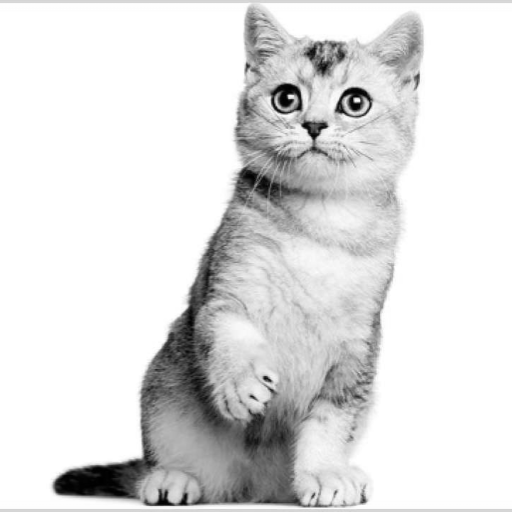

In [19]:
state2image(image2state(cat, reorder=True), reorder=True)

## Trace out qubits from image

When we eliminate a qubit from an image, we obtain a density matrix. We start with the initial state
$$|\psi\rangle = \sum_s \psi_s |s\rangle,$$
where $s=s_1s_2\cdots s_N$ is a binary number with all qubits.

We now separate into the qubits we keep $r=s_1s_2\cdots s_M$ and the ones we eliminate $u=s_{M+1}\cdots s_N.$
$$|\psi\rangle = \sum_s \psi_{r,u}|r\rangle|u\rangle.$$
This is just a relabelling.

We construct the density matrix
$$\rho = \sum_{r,r'} \rho(r,r') |r\rangle\langle r'|$$
with the elimination of the "traced out" degrees of freedom
$$\rho(r,r') = \sum_{u} \psi_{r,u} \psi_{r',u}^*.$$

As before, we interpret $I(r),$ the intensity of our image, as the probability of excitation. However, because now we have a density matrix, the intensity appears on the diagonal of the matrix
$$I(r) \propto \rho(r,r).$$

The following function does this. It returns an image (not a state) with the resampled information.

In [20]:
def resample(ψ, nqubits=None, reorder=True):
    q = int(np.round(np.log2(ψ.size)))
    if nqubits is None:
        nqubits = q-2
    elif nqubits < 0:
        nqubits = q + nqubits
    
    L1 = 2**nqubits
    L2 = ψ.size // L1
    
    #
    # We are now going to extract the diagonal of
    # the reduced density matrix, and output it as a
    # new image
    if True:
        I = np.einsum('kii->k',
                      ψ.reshape((L1, L2, 1)) * ψ.conj().reshape(L1, 1, L2))
    else:
        # This is very slow and consumes a lot of memory
        ρ = ψ.reshape((L1,L2)) @ ψ.reshape((L1,L2)).T.conj()
        I = np.diag(ρ)

    # We may need to undo the ordering of qubits
    I = order_by_dimension(I, nqubits//2)
        
    # Intensity is now a vector. We have to rearrange it into
    # a square matrix for converting it to an image
    L = 2**(nqubits//2)
    return intensity2image(I.reshape((L,L)))

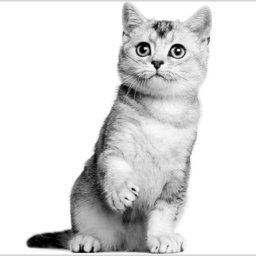

In [21]:
resample(image2state(cat), -2)

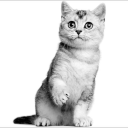

In [22]:
resample(image2state(cat), -4)

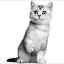

In [23]:
resample(image2state(cat), -6)

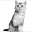

In [24]:
resample(image2state(cat), -8)

## Enlarge image without interpolation

We can play a similar trick, to make an image from $L\times L$ to $2^{n}L\times 2^{n}L$ pixels, by adding $n$ empty qubits to an existing image.

In other words, we go from
$$|\psi\rangle = \sum_s \psi_s |s\rangle$$
to this trivial expansion
$$|\psi'\rangle = \sum_s  \psi_s |s,0,0,\ldots, 0\rangle.$$

This works if we are using the size-based order!

In [25]:
def enlarge(ψ, nqb):
    
    ψ = ψ.reshape((ψ.size,1)) * np.ones((1,2**nqb))
    ψ = ψ.flatten()
    return ψ / np.linalg.norm(ψ)

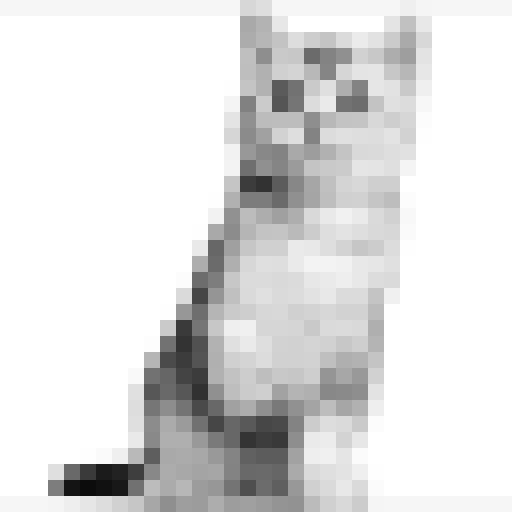

In [26]:
state2image(enlarge(image2state(resample(image2state(cat), -8)), 8))

##  Same, but Gaussians

In [27]:
def Gaussian(nqb, σ=0.1, reorder=True):
    
    x = np.linspace(-1, 1, 2**nqb)
    f = np.exp(-0.5 * (x/σ)**2)
    f /= np.linalg.norm(f)
    
    ψ = f.reshape((1,2**nqb)) * f.reshape((2**nqb,1))
    
    if reorder:
        ψ = order_by_size(ψ, nqb)
    
    return ψ / np.linalg.norm(ψ.flatten())

In [28]:
aux = state2image(Gaussian(9, 0.2))

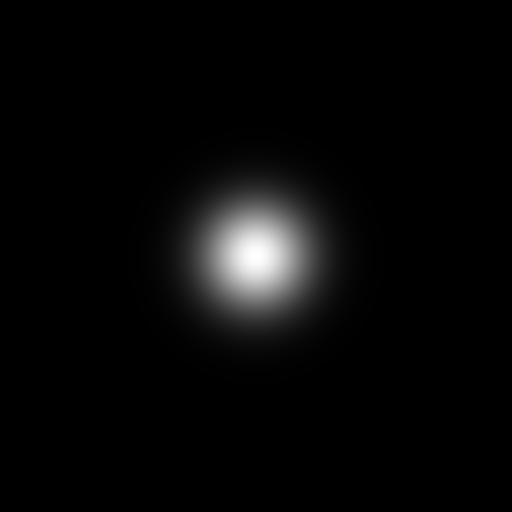

In [29]:
aux

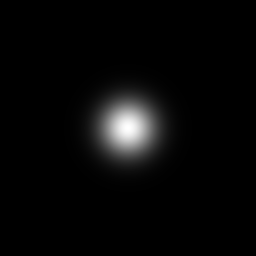

In [30]:
resample(image2state(aux), -2)

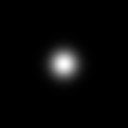

In [31]:
resample(image2state(aux), -4)

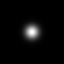

In [32]:
resample(image2state(aux), -6)

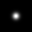

In [33]:
resample(image2state(aux), -8)

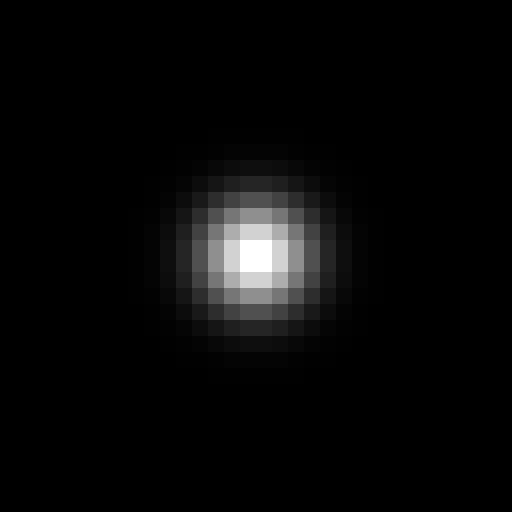

In [34]:
state2image(enlarge(image2state(resample(image2state(aux), -8)), 8))

## Schmidt decompositions

When we create a quantum state, we may need more or less quantum operations, depending on how "complex" the state is. One way to understand this complexity is to study the entanglement through "Schmidt decompositions."

A Schmidt decomposition for a state with N qubits is a splitting of the many-qubit state into two groups, one with L qubits and one with R=N-L. Typically, these splittings are done "in order" and we talk about "left" and "right" qubits.

Once we have this regrouping, we wonder how we can transform the state
$$|\psi\rangle = \sum_s \psi(s_1,\ldots s_N) |s_1\ldots s_L\rangle|s_{L+1}\ldots s_N\rangle$$
into a quantum superposition
$$|\psi\rangle = \sum_i \sqrt{\lambda_i} |\phi_i\rangle|\xi_i\rangle,$$
where $\phi$ and $\xi$ are states for the L (left) and R (right qubits). We also want this decomposition to be optimal, with the smallest number of states.

The following function computes the Schmidt numbers $\lambda_i$ using a trick called the Singular Value Decomposition (SVD). We do the same splitting as before, rewriting the vector as a matrix
$$\psi(s) \to \psi(l, r)$$
where $l$ are the bits for the "left" and $r$ the bits for the right indices. We finally decompose
$$\psi(l,r) = \Phi \Lambda^{1/2} \Xi^T$$
where $\Lambda_{ii} = \lambda_i$ is a diagonal matrix of Singular Values, and $\Phi$ and $\Xi$ are unitary matrices that contain (as columns) the decompositions of $\phi_i$ and $\xi_i.$

In [35]:
def Schmidt(ψ, qubits_left=1):
    Lleft = 2**qubits_left
    Lright = ψ.size // Lleft
    ψ = ψ / np.linalg.norm(ψ)
    A = ψ.reshape((Lleft, Lright))
    
    Φ, sqrtΛ, Ξ = np.linalg.svd(A)
    return (sqrtΛ)**2

The following plot shows that the cat state has many more states participating into the superposition, because it has a large collection of states (with small weights, $10^{-3}-10^{-6}$) required to encode the details of the image. The Gaussian, on the other hand, is a much simpler structure

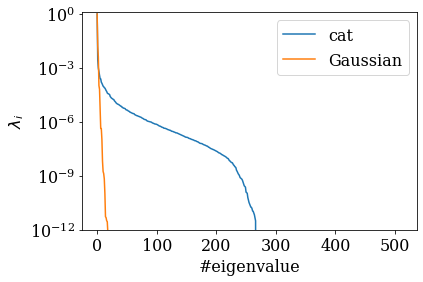

In [36]:
ψGaus = Gaussian(9, 0.2)
ψcat = image2state(cat)

fig, ax = plt.subplots()
ax.plot(Schmidt(ψcat, 9), label='cat')
ax.plot(Schmidt(ψGaus, 9), label='Gaussian')
ax.set_ylabel('$\\lambda_i$')
ax.set_xlabel('#eigenvalue')
ax.set_yscale('log')
ax.set_ylim([1e-12,1.2])
ax.legend();

## Exercises

**Exercise 1**

Download a different image from the internet. Perform a similar study, comparing also the distribution of states in the Schmidt decomposition above.

**Exercise 2**

Instead of adding zeros, investigate what happens when you add qubits in a random state.

**Exercise 3**

Investigate the type of entanglement required to represent other mathematical functions.

**Exercise 4**

Using Qiskit, find out the quantum circuit required to encode a simple image, such as the Gaussian as represented by 3+3 qubits.